# Classify authors by metadata
Let's try to expand the coverage of local vs. non-local authors using the raw posts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import dateutil

## Load data

In [3]:
user_data = pd.read_csv('../../data/mined_tweets/tweet_user_data/user_data_archive.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
user_data.fillna('', inplace=True)
print(user_data.shape[0])
display(user_data.head())
author_var = 'username'
data_name_var = 'data_name_fixed'
date_var = 'date'
user_meta_vars = ['location', 'description', 'followers_count', 'friends_count', 'created_at']
user_data.sort_values([author_var, date_var], inplace=True, ascending=True)
user_dedup = user_data.drop_duplicates([author_var, data_name_var]).loc[:, user_meta_vars + [author_var, data_name_var]]
print(user_dedup.shape[0])

310514


,name,id,location,description,followers_count,friends_count,statuses_count,created_at,verified,date,data_name_fixed,username
0,Xavier Mitjavila Moix,1024378674651574272,barcelona,"Xavier Mitjavila Moix de París, Francia y Barc...",163,43,18485,Tue Jul 31 19:38:02 +0000 2018,False,2018-09-03,florence,xaviermitjavila
1,Muhemmed Asfand Yar,48365860,"New York, USA",Google Expert #DigitalMarketing #SEO #SEM #Soc...,602,399,131224,Thu Jun 18 14:30:14 +0000 2009,False,2018-09-03,florence,muhemmedasfand
2,Snowbie,730825682,"Dublin City, Ireland","Forecaster for http://Metcast.net, senior mode...",992,1140,20599,Wed Aug 01 14:52:44 +0000 2012,False,2018-09-03,florence,bruensryan
3,Deplorable Diana +++,19195060,I Block Trolls USA,This is a PC FREE Zone! There is a possibility...,2637,2975,58774,Mon Jan 19 18:38:04 +0000 2009,False,2018-09-03,florence,fancygap1
4,"William E. Lewis, Jr",29753150,"Fort Lauderdale, Florida",Former AM radio talk show host @AM740WSBR @AM1...,12458,10385,274683,Wed Apr 08 16:24:57 +0000 2009,False,2018-09-03,florence,4billlewis


57071


In [58]:
from ast import literal_eval
## load full data
author_var = 'username'
data_name_var = 'data_name_fixed'
txt_var = 'txt'
NE_list_var = 'NE_list'
usecols = [author_var, data_name_var, txt_var, NE_list_var]
full_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data.gz', sep='\t', index_col=False, compression='gzip', converters={'NE_list' : literal_eval}, usecols=usecols)
## restrict NE list to tokens
full_data = full_data.assign(**{
    'NE_list_tokens' : full_data.loc[:, NE_list_var].apply(lambda x: [y[0] for y in x])
})

In [59]:
full_data.loc[:, 'NE_list_tokens'].iloc[:10]

0                      []
1                      []
2      [POTUS, Hurricane]
3                      []
4                      []
5                      []
6                      []
7         [Trump, island]
8    [Op_RUMAN, Dominica]
9                      []
Name: NE_list_tokens, dtype: object

Let's mark local/non-local authors based on `location` field.

In [7]:
import re
from data_helpers import DATA_NAME_STATES_LOOKUP
DATA_NAME_STATES_MATCHER = {
    k : re.compile('|'.join(['(?<=[, ])%s$|^%s,\s+'%((loc.lower(),)*2) for loc in v]))
    for k,v in DATA_NAME_STATES_LOOKUP.items()
}
print(DATA_NAME_STATES_MATCHER['florence'].pattern)

(?<=[, ])fl$|^fl,\s+|(?<=[, ])nc$|^nc,\s+|(?<=[, ])sc$|^sc,\s+|(?<=[, ])va$|^va,\s+|(?<=[, ])ga$|^ga,\s+|(?<=[, ])florida$|^florida,\s+|(?<=[, ])north carolina$|^north carolina,\s+|(?<=[, ])south carolina$|^south carolina,\s+|(?<=[, ])virginia$|^virginia,\s+|(?<=[, ])georgia$|^georgia,\s+


In [8]:
loc_var = 'location'
local_var = 'is_local'
user_dedup = user_dedup.assign(**{
    local_var : user_dedup.apply(lambda x: DATA_NAME_STATES_MATCHER[x.loc[data_name_var]].search(x.loc[loc_var].lower()) is not None, axis=1)
})

In [9]:
print('%d/%d local authors'%(user_dedup.loc[:, local_var].sum(), user_dedup.shape[0]))

12066/57071 local authors


In [61]:
full_user_data = pd.merge(full_data, user_dedup.loc[:, [author_var, data_name_var, local_var]], on=[author_var, data_name_var], how='inner')
print('%d/%d authors represented'%(full_user_data.loc[:, author_var].nunique(), full_data.loc[:, author_var].nunique()))

12178/1353597 authors represented


### Test local/non-local classification
Let's start off with a basic BOW classifier.

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,3), max_features=5000, lowercase=True, stop_words='english')
# group text by author: one doc per author
author_txt = full_user_data.groupby(author_var).apply(lambda x: ' '.join(x.loc[:, 'txt'].values))
author_labels = np.array([x for x in full_user_data.groupby(author_var).apply(lambda x: x.loc[:, local_var].iloc[0])]).astype(int)
author_txt_dtm = cv.fit_transform(author_txt)
print(author_txt_dtm.shape)

(12178, 5000)


In [45]:
## most frequent features
author_txt_dtm_sum = pd.Series(np.squeeze(np.array(author_txt_dtm.sum(axis=0))), index=sorted(cv.vocabulary_, key=lambda x: cv.vocabulary_[x]))
author_txt_dtm_sum.sort_values(ascending=False, inplace=True)
display(author_txt_dtm_sum.head(20))

url                  58014
irma                 28478
hurricaneirma        14913
puertorico           13156
hurricane            10201
florida               9392
rt                    9288
harvey                6812
irma url              5488
hurricane irma        4556
storm                 4497
maria                 4405
help                  4049
miami                 3935
hurricaneirma url     3665
power                 3576
hurricanemaria        3502
people                3302
trump                 3261
hurricanemichael      3111
dtype: int64

In [52]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
## balance data
logit = LogisticRegression(class_weight='balanced', solver='lbfgs')
## cross-validation
cross_val_folds = 10
cross_val_results = cross_validate(logit, author_txt_dtm, author_labels, cv=cross_val_folds)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/pyt

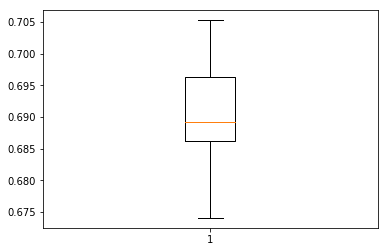

In [53]:
plt.boxplot(cross_val_results['test_score'])
plt.show()

Overall we get a pretty low accuracy. Not good!

Maybe we'll have better luck with the NEs that authors use.

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,1), max_features=5000, lowercase=True, stop_words='english')
# group text by author: one doc per author
NE_token_var = 'NE_list_tokens'
author_NE_txt = full_user_data.groupby(author_var).apply(lambda x: ' '.join([z for y in x.loc[:, NE_token_var] for z in y]))
author_labels = np.array([x for x in full_user_data.groupby(author_var).apply(lambda x: x.loc[:, local_var].iloc[0])]).astype(int)
author_NE_txt_dtm = cv.fit_transform(author_NE_txt)
print(author_NE_txt_dtm.shape)

(12178, 5000)


In [77]:
## most frequauthor_NE_txt_dtm_sument features
author_NE_txt_dtm_sum = pd.Series(np.squeeze(np.array(author_NE_txt_dtm.sum(axis=0))), index=sorted(cv.vocabulary_, key=lambda x: cv.vocabulary_[x]))
author_NE_txt_dtm_sum.sort_values(ascending=False, inplace=True)
display(author_NE_txt_dtm_sum.head(20))

florida           4752
miami             2261
irma              1823
puerto_rico       1803
houston           1658
san_juan          1433
trump             1379
fl                1229
naples            1086
huracán            949
tampa              807
texas              795
hurricane          784
harvey             715
georgia            639
north_carolina     593
hurricane_irma     576
florida_keys       544
florence           525
nc                 510
dtype: int64

In [78]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
## balance data
logit = LogisticRegression(class_weight='balanced', solver='lbfgs')
## cross-validation
cross_val_folds = 10
cross_val_results = cross_validate(logit, author_NE_txt_dtm, author_labels, cv=cross_val_folds)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/pyt

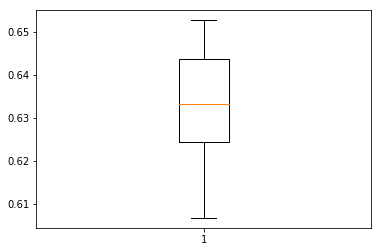

In [79]:
plt.boxplot(cross_val_results['test_score'])
plt.show()

Wow this is worse. 

### Classify local vs. non-local per-dataset
Wait a second. We should be modeling the conditional probability of local authorship based on the data. e

Example: $P(\text{local} | \text{San Juan}, \text{Maria}) \neq P(\text{local} | \text{San Juan}, \text{Harvey})$.

Let's train a separate classifier for each dataset.

In [85]:
def fit_test_model(data, author_var='username', txt_var='txt', dep_var='is_local', cross_val_folds=10, max_features=5000, ngram_range=(1,1), reg_weight_C=0.01):
    cv = CountVectorizer(ngram_range=(1,3), max_features=max_features, lowercase=True, stop_words='english')
    # group text by author: one doc per author
    author_txt = data.groupby(author_var).apply(lambda x: ' '.join(x.loc[:, txt_var].values))
    author_labels = np.array([x for x in data.groupby(author_var).apply(lambda x: x.loc[:, dep_var].iloc[0])]).astype(int)
    author_txt_dtm = cv.fit_transform(author_txt)
    ## balance data
    logit = LogisticRegression(class_weight='balanced', solver='lbfgs', C=reg_weight_C)
    ## cross-validation
    cross_val_results = cross_validate(logit, author_txt_dtm, author_labels, cv=cross_val_folds)
    return cross_val_results
    
data_name_var = 'data_name_fixed'
cross_val_folds = 10
txt_var = 'txt'
ngram_range = (1,1)
max_features = 1000
for data_name_i, data_i in full_user_data.groupby(data_name_var):
    print('data=%s'%(data_name_i))
    results_i = fit_test_model(data_i, txt_var=txt_var, cross_val_folds=cross_val_folds, ngram_range=ngram_range, max_features=max_features)
    train_mean_i = np.mean(results_i['train_score'])
    test_mean_i = np.mean(results_i['test_score'])
    train_sd_i = np.std(results_i['train_score']) / (cross_val_folds**.5)
    test_sd_i = np.std(results_i['test_score']) / (cross_val_folds**.5)
    print('mean train score = %.3f +/- %.3f'%(train_mean_i, train_sd_i))
    print('mean test score = %.3f +/- %.3f'%(test_mean_i, test_sd_i))

data=florence


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


mean train score = 0.779 +/- 0.002
mean test score = 0.685 +/- 0.016
data=harvey


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


mean train score = 0.684 +/- 0.001
mean test score = 0.629 +/- 0.008
data=irma


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


mean train score = 0.768 +/- 0.001
mean test score = 0.723 +/- 0.005
data=maria


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


mean train score = 0.896 +/- 0.004
mean test score = 0.857 +/- 0.010
data=michael
mean train score = 0.803 +/- 0.002
mean test score = 0.673 +/- 0.011


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Classify authors by media account vs. personal account
Can we determine whether an author is posting from a media account versus a personal account? Some say [yes](https://www.aclweb.org/anthology/W16-3904).

First we need to label the accounts manually.

In [139]:
label_cols = ['username', 'description', 'followers_count', 'data_name_fixed']
label_file = '../../data/mined_tweets/tweet_user_data/user_data_media_label.tsv'
# get even sample from all datasets
data_name_var = 'data_name_fixed'
np.random.seed(123)
sample_size = 100
# sample_size = 500 # TODO: ambitious goal => build separate classifier with labelled data
user_label_data = user_dedup.groupby(data_name_var).apply(lambda x: x.loc[np.random.choice(x.index, sample_size, replace=False), :]).reset_index(drop=True)
print(user_label_data.shape[0])
user_label_data.to_csv(label_file, columns=label_cols, sep='\t', index=False)

2500


In [140]:
# after labelling
user_label_data_clean = pd.read_csv('../../data/mined_tweets/tweet_user_data/user_data_media_label_clean.tsv', sep='\t', index_col=False)
user_label_data_clean.fillna('', inplace=True)
org_var = 'organization'
print('%d/%d organizations'%(user_label_data_clean.loc[:, org_var].sum(), user_label_data_clean.shape[0]))

94/500 organizations


This is a bit small for classifying, but we can at least which words are more correlated with organizations.

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
def get_word_counts(txt):
    cv = CountVectorizer(ngram_range=(1,3), min_df=0., stop_words='english')
    dtm = cv.fit_transform(txt)
    word_counts = np.squeeze(np.array(dtm.sum(axis=0)))
    word_counts = pd.Series(word_counts, index=sorted(cv.vocabulary_, key=lambda x: cv.vocabulary_[x]))
    return word_counts
description_var = 'description'
org_txt = user_label_data_clean[user_label_data_clean.loc[:, org_var]==1].loc[:, description_var].values
non_org_txt = user_label_data_clean[user_label_data_clean.loc[:, org_var]==0].loc[:, description_var].values
org_word_counts = get_word_counts(org_txt)
non_org_word_counts = get_word_counts(non_org_txt)
# add null vocab, smooth
vocab = org_word_counts.index | non_org_word_counts.index
org_word_counts = org_word_counts.loc[vocab].fillna(0, inplace=False) + 1.
non_org_word_counts = non_org_word_counts.loc[vocab].fillna(0, inplace=False) + 1.
org_odds = org_word_counts / non_org_word_counts
org_odds.sort_values(inplace=True, ascending=False)
display(org_odds.head(20))

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()


fox                      5.0
site                     5.0
group                    5.0
updates                  5.0
accuweather              4.0
online                   4.0
company                  4.0
official twitter         4.0
feed                     4.0
official twitter feed    4.0
page                     4.0
fm                       4.0
health                   4.0
shrimp                   4.0
boxeo                    4.0
latest news              4.0
wine                     4.0
twitter feed             4.0
latest                   3.5
emergency                3.5
dtype: float64

No surprises! "Official" and "emergency" seem to be organization-specific words.

### Detect organizations with pretrained model
Let's cut the line and use [this code](https://bitbucket.org/mdredze/demographer/src/peoples2018/) to detect organization.

```
git clone https://bitbucket.org/mdredze/demographer.git --branch peoples2018
cd demographer
python setup.py install
```

In [205]:
user_data = pd.read_csv('../../data/mined_tweets/tweet_user_data/user_data.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
user_data.fillna('', inplace=True)
print(user_data.shape[0])
display(user_data.head())
author_var = 'username'
data_name_var = 'data_name_fixed'
date_var = 'date'
user_meta_vars = ['location', 'description', 'followers_count', 'friends_count', 'created_at', 'statuses_count', 'verified', 'name']
user_data.sort_values([author_var, date_var], inplace=True, ascending=True)
user_dedup = user_data.drop_duplicates([author_var, data_name_var]).loc[:, user_meta_vars + [author_var, data_name_var]]
print(user_dedup.shape[0])

310514


,name,id,location,description,followers_count,friends_count,statuses_count,created_at,verified,date,data_name_fixed,username
0,Xavier Mitjavila Moix,1024378674651574272,barcelona,"Xavier Mitjavila Moix de París, Francia y Barc...",163,43,18485,Tue Jul 31 19:38:02 +0000 2018,False,2018-09-03,florence,xaviermitjavila
1,Muhemmed Asfand Yar,48365860,"New York, USA",Google Expert #DigitalMarketing #SEO #SEM #Soc...,602,399,131224,Thu Jun 18 14:30:14 +0000 2009,False,2018-09-03,florence,muhemmedasfand
2,Snowbie,730825682,"Dublin City, Ireland","Forecaster for http://Metcast.net, senior mode...",992,1140,20599,Wed Aug 01 14:52:44 +0000 2012,False,2018-09-03,florence,bruensryan
3,Deplorable Diana +++,19195060,I Block Trolls USA,This is a PC FREE Zone! There is a possibility...,2637,2975,58774,Mon Jan 19 18:38:04 +0000 2009,False,2018-09-03,florence,fancygap1
4,"William E. Lewis, Jr",29753150,"Fort Lauderdale, Florida",Former AM radio talk show host @AM740WSBR @AM1...,12458,10385,274683,Wed Apr 08 16:24:57 +0000 2009,False,2018-09-03,florence,4billlewis


57071


In [206]:
## convert to JSON
org_detect_cols = ['location', 'description', 'username', 'friends_count', 'followers_count', 'created_at', 'statuses_count', 'verified', 'name']
org_detect_null_cols = ['listed_count']
author_var = 'username'
org_detect_data = user_dedup.drop_duplicates(author_var, inplace=False).loc[:, org_detect_cols].rename(columns={author_var : 'screen_name'})
# give 0 for missing data
org_detect_data = org_detect_data.assign(**{k : 0. for k in org_detect_null_cols})
# org_detect_data = org_detect_data.assign(**{'name' : org_detect_data.loc[:, 'screen_name'].apply(lambda x: x.replace('_', ' '))})
org_detect_data_json = org_detect_data.apply(lambda x: x.to_json(), axis=1).values
org_detect_input_file = 'demographer/data/test_org_detect_tweets.txt'
with open(org_detect_input_file, 'w') as org_detect_input:
    org_detect_input.write('\n'.join(org_detect_data_json))

Run the following command in-line: 
```
cd demographer/
python -m demographer.cli.process_tweets --classifier organization --model simple --input data/test_org_detect_tweets.txt --output data/test_org_detect_tweets_labelled.txt
```

In [207]:
import json
org_detect_output_file = 'demographer/data/test_org_detect_tweets_labelled.txt'
org_detect_output = [json.loads(x) for x in open(org_detect_output_file, 'r')]
# convert to dataframe
label_cols = ['screen_name']
org_data_label = pd.DataFrame([[x[c] for c in label_cols] + [x['demographics']['indorg']['value'], x['demographics']['indorg']['scores'][x['demographics']['indorg']['value']]] for x in org_detect_output])
org_data_label.columns = label_cols + ['label', 'label_score']
org_data_label = org_data_label.assign(**{'organization' : (org_data_label.loc[:, 'label']=='org').astype(int)})
org_data_label = org_data_label.rename(columns={'screen_name': 'username'})
display(org_data_label.head())
print(org_data_label.loc[:, 'label'].value_counts())

,username,label,label_score,organization
0,007puk,ind,-3.265107,0
1,00titulares,ind,-1.065407,0
2,0111kek0111,ind,-1.723073,0
3,02cents0,ind,-2.053307,0
4,03steve15,ind,-4.604235,0


ind    46413
org     4568
Name: label, dtype: int64


In [208]:
user_label_data_clean = pd.read_csv('../../data/mined_tweets/tweet_user_data/user_data_media_label_clean.tsv', sep='\t', index_col=False)
user_label_data_clean.fillna('', inplace=True)
display(user_label_data_clean.head())

,username,data_name_fixed,description,followers_count,organization
0,_angieweems,florence,"God,Family, Boxer Dog Lover,Greene County Sher...",828,0
1,shaunajwv,florence,"Reporter, @WVMetroNews Radio Network; Co-Ancho...",2252,0
2,carolinapetes,florence,"Christian, 🏌️Golf Life🏌️‍♀️#PGA ***Follow us i...",1628,0
3,gregfordnc,florence,"Husband, Dad, Wake County Commissioner. Former...",617,0
4,cryptokells,florence,Living the Colorado Life! + Crypto Enthusiast!...,131,0


In [209]:
def score_labels(data_label, data_gold, label_var='organization'):
    # score precision/recall on org labels
    tp_data = (data_label.loc[:, label_var] - data_gold.loc[:, label_var]==0) & (data_label.loc[:, label_var]==1)
    fp_data = (data_label.loc[:, label_var] - data_gold.loc[:, label_var] == 1)
    fn_data = (data_label.loc[:, label_var] - data_gold.loc[:, label_var] == -1)
    tp = tp_data.sum()
    fp = fp_data.sum()
    fn = fn_data.sum()
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    return tp_data, fp_data, fn_data, prec, rec

In [210]:
author_var = 'username'
label_var = 'organization'
data_label = org_data_label.loc[:, [author_var, 'label_score', label_var]]
data_gold = user_label_data_clean.loc[:, [author_var, label_var]]
# limit to shared authors
shared_users = set(data_label.loc[:, author_var].unique()) & set(data_gold.loc[:, author_var].unique())
data_label = data_label[data_label.loc[:, author_var].isin(shared_users)]
data_gold = data_gold[data_gold.loc[:, author_var].isin(shared_users)]
# drop duplicate authors
data_gold.drop_duplicates(author_var, inplace=True)
data_label.drop_duplicates(author_var, inplace=True)
# same order
data_gold.sort_values(author_var, inplace=True, ascending=True)
data_label.sort_values(author_var, inplace=True, ascending=True)
data_label.index = data_gold.index
tp_data, fp_data, fn_data, prec, rec = score_labels(data_label, data_gold, label_var=label_var)
print('organization labels: prec=%.3f, rec=%.3f'%(prec, rec))

organization labels: prec=0.871, rec=0.535


In [212]:
# show false positive examples
print('false positives')
display(data_gold[fp_data].loc[:, author_var].unique())
# show false negative examples
print('false negatives')
display(data_gold[fn_data].loc[:, author_var].unique())

false positives


array(['airlivenet', 'corkgaines', 'edison_electric', 'figment_imagine',
       'noircoffeegroup', 'sjearthquakes', 'spencerweather',
       'ucf_marcdaniels'], dtype=object)

false negatives


array(['1025wfmf', 'allhandsdotnet', 'alt1053', 'americares',
       'asicentral', 'austinpetsalive', 'awhonn', 'bbb_enterprise',
       'bethuneformb', 'bridge_golf', 'chambanawx', 'chicagosmayor',
       'chrisdisaster', 'cincyshrimp', 'clemprograms', 'complyethic',
       'computercareon', 'conedison', 'dpltoday', 'earth_hazards',
       'enlacanchapr', 'fox_chattanooga', 'georgiapower',
       'gerdasequineres', 'glazingblogger', 'goexpresstruck',
       'heart911team', 'hhazelwoodesq', 'hibbertgroupre', 'humanesociety',
       'kbtrealtyteam', 'lemondnutrition', 'livemapus', 'loopnewsbb',
       'matt_barrentine', 'mcsweeneycac', 'mtzionnashville',
       'myarklamiss', 'ncweatherhound', 'nwswpc', 'pinksugarmiami',
       'qtweather', 'specifiermagcsi', 'tachiractiva', 'wbbj7weather',
       'wvtm13', 'xwnetwork'], dtype=object)

It doesn't seem like there's a consistent bias toward certain types of accounts that are misidentified (mix of weather, news, government accounts). This is a good sign. We can use the classifier to get high-precision data on organizations and then compare rates of context use among organizations and non-organizations, in the same way that we compared locals and non-locals.